In [1]:
import sys, os, json, random
import torch
import sys
import datetime

import cv2

import numpy as np
import pandas as pd

import skimage.io as io

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
%matplotlib inline

from shapely.geometry import Polygon

# path to the images
data_dir = "C:/Users/kurt_/car-parts-and-damage-detection-v18/car-damage-detection/car-damages/File1"

# create paths for traininig and validaiton data
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v18/car-damage-detection/working/data/", exist_ok=True)
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v18/car-damage-detection/working/data/train/", exist_ok=True)
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v18/car-damage-detection/working/data/val/", exist_ok=True)

# create path to store the model config
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v18/car-damage-detection/working/model/", exist_ok=True)

data_working_dir = "C:/Users/kurt_/car-parts-and-damage-detection-v18/car-damage-detection/working/data/"
model_dir = "C:/Users/kurt_/car-parts-and-damage-detection-v18/car-damage-detection/working/model/"

In [2]:
import json
import os
import shutil
import random
from PIL import Image

images_dir = os.path.join(data_dir, "img")
annotations_dir = os.path.join(data_dir, "ann")


# Get list of images
images = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

# Shuffle the images
random.shuffle(images)

# Split the dataset (e.g., 80% train, 20% val)
split_index = int(0.8 * len(images))
train_images = images[:split_index]
val_images = images[split_index:]

def convert_to_coco(images, images_dir, annotations_dir, output_dir):
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    category_mapping = {
        "Dent": 1,
        "Scratch": 2,
        "Broken part": 3,
        "Paint chip": 4,
        "Missing part": 5,
        "Flaking": 6,
        "Corrosion": 7,
        "Cracked": 8
    }

    for category, id in category_mapping.items():
        coco_output["categories"].append({
            "id": id,
            "name": category
        })

    annotation_id = 1
    for idx, image_filename in enumerate(images):
        image_path = os.path.join(images_dir, image_filename)
        annotation_path = os.path.join(annotations_dir, image_filename + ".json")
        
        # Copy the image to the output directory
        shutil.copy(image_path, output_dir)
        
        # Open the image to get its dimensions
        with Image.open(image_path) as img:
            width, height = img.size
        
        coco_output["images"].append({
            "file_name": image_filename,
            "height": height,
            "width": width,
            "id": idx
        })
        
        with open(annotation_path) as f:
            objs = json.load(f)["objects"]

        for obj in objs:
            px = [point[0] for point in obj["points"]["exterior"]]
            py = [point[1] for point in obj["points"]["exterior"]]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            category_id = category_mapping.get(obj["classTitle"], -1)
            if category_id == -1:
                continue  # Skip unknown categories
            
            bbox = [min(px), min(py), max(px) - min(px), max(py) - min(py)]
            
            coco_output["annotations"].append({
                "bbox": bbox,
                "category_id": category_id,
                "image_id": idx,
                "segmentation": [poly],
                "area": bbox[2] * bbox[3],
                "iscrowd": 0,
                "id": annotation_id
            })
            annotation_id += 1

    return coco_output

train_output = convert_to_coco(train_images, images_dir, annotations_dir, os.path.join(data_working_dir, "train"))
val_output = convert_to_coco(val_images, images_dir, annotations_dir, os.path.join(data_working_dir, "val"))

with open(os.path.join(data_working_dir, "train", "annotations.json"), "w") as f:
    json.dump(train_output, f, indent=4)

with open(os.path.join(data_working_dir, "val", "annotations.json"), "w") as f:
    json.dump(val_output, f, indent=4)

In [3]:
from detectron2.data.datasets import register_coco_instances

# Register train and val datasets
register_coco_instances("car_train", {}, os.path.join(data_working_dir, "train", "annotations.json"), os.path.join(data_working_dir, "train"))
register_coco_instances("car_val", {}, os.path.join(data_working_dir, "val", "annotations.json"), os.path.join(data_working_dir, "val"))

# Load metadata
from detectron2.data import MetadataCatalog
car_metadata = MetadataCatalog.get("car_train")

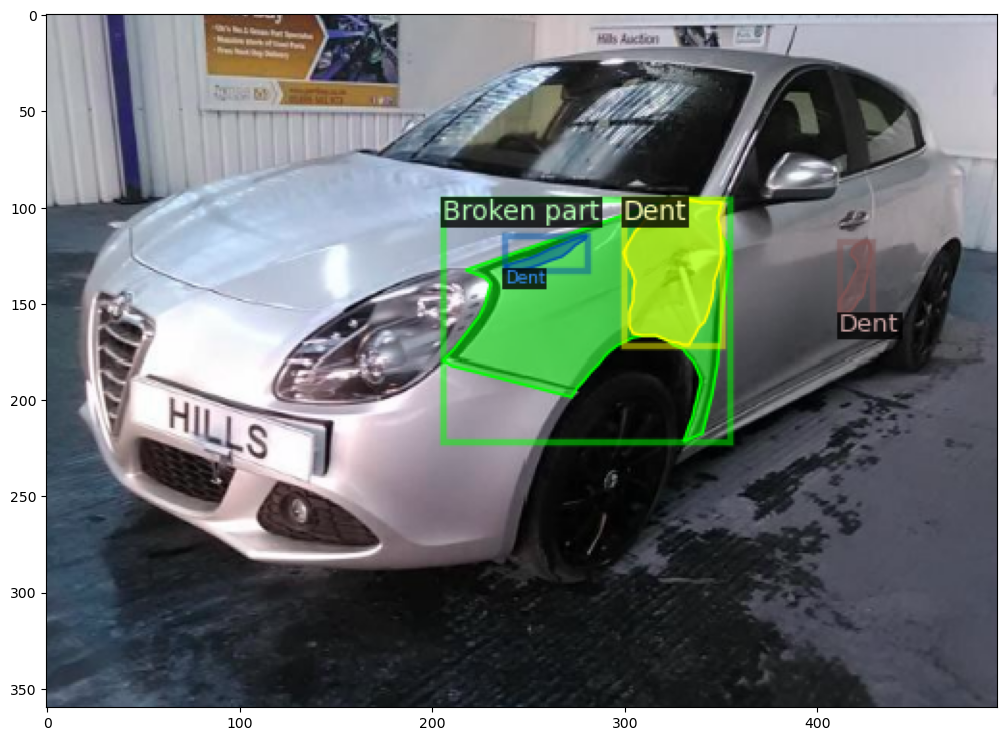

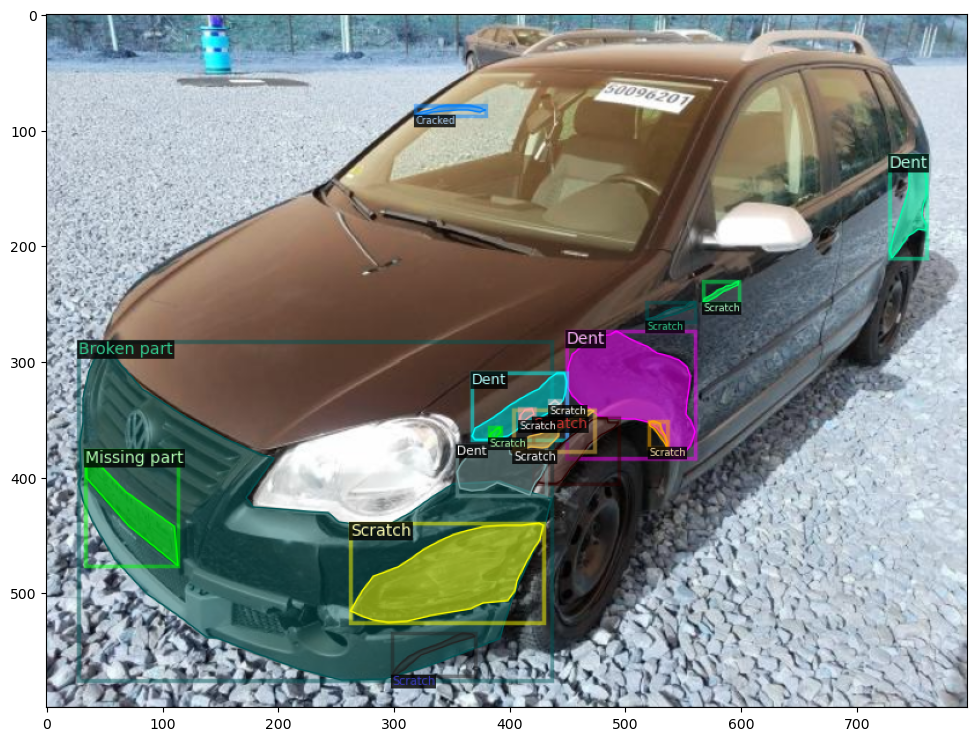

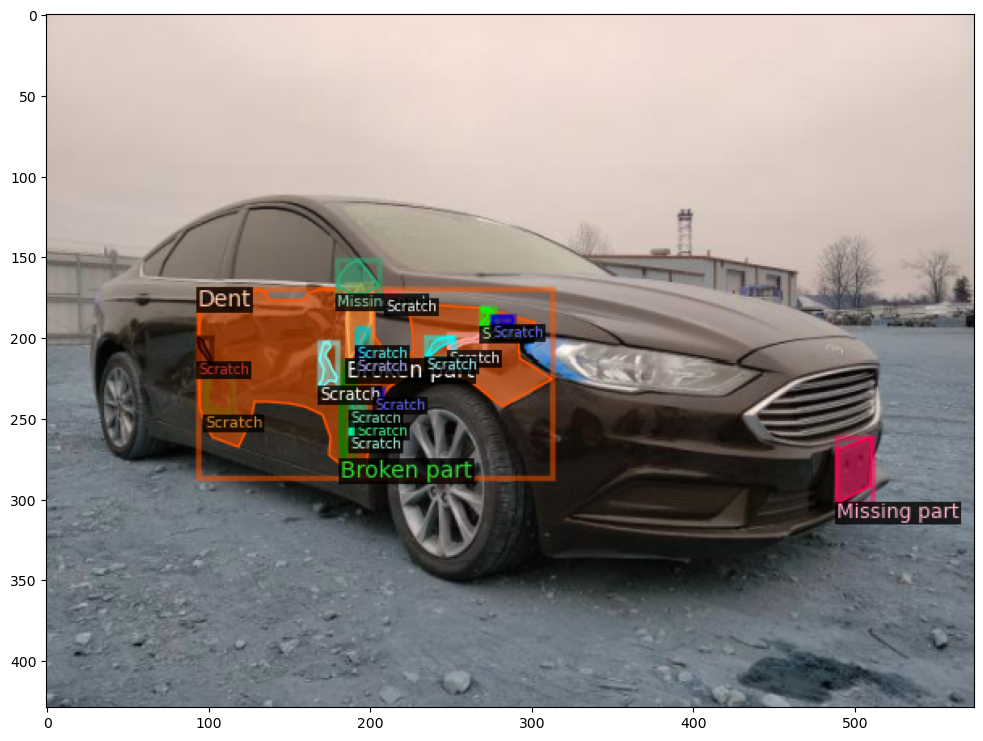

In [4]:
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog

dataset_dicts = DatasetCatalog.get("car_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=car_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [5]:
import os
import torch
import detectron2
import datetime
from detectron2.engine import DefaultTrainer, hooks, HookBase
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data.transforms import (
    RandomFlip,
    RandomBrightness,
    RandomContrast,
    RandomRotation,
    ResizeShortestEdge
)

# Define output directory
output_dir = "./output_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Create configuration
cfg = get_cfg()

# Set output directory
cfg.OUTPUT_DIR = output_dir

# Merge configuration from the model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

# Set training and testing datasets
cfg.DATASETS.TRAIN = ("car_train",)
cfg.DATASETS.TEST = ("car_val",)  # for evaluation during training
cfg.DATALOADER.NUM_WORKERS = 8

# Set device to cuda if available
cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set weights from the model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo

# Set batch size, learning rate, and maximum iterations
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00075 
cfg.SOLVER.MAX_ITER = 10000  # Increase the maximum number of iterations
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.INPUT.MASK_FORMAT = 'polygon'

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WARMUP_ITERS = 250
cfg.TEST.EVAL_PERIOD = 2000

# Set batch size per image and number of classes
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # images used to calculate cls and reg loss during training.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # total number of classes


# Create output directory if it does not exist
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Custom Trainer to add hooks for status updates
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        from detectron2.evaluation import COCOEvaluator, inference_on_dataset, print_csv_format
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    @classmethod
    def build_train_loader(cls, cfg):
        """
        Customize the data loader to include data augmentation during training.
        """
        return build_detection_train_loader(
            cfg,
            mapper=DatasetMapper(cfg, is_train=True, augmentations=[
                RandomFlip(prob=0.5),  # Randomly flip the image horizontally
                RandomBrightness(0.8, 1.2),  # Adjust brightness randomly
                RandomContrast(0.8, 1.2),  # Adjust contrast randomly
                RandomRotation(angle=[-10, 10]),  # Rotate images within the range -10 to 10 degrees
                ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333)  # Standard resizing
            ])
        )

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(0, PrintTrainingStatus())
        return hooks

# Custom hook to print training status
class PrintTrainingStatus(HookBase):
    def after_step(self):
        # Print training status every 500 iterations
        if self.trainer.iter % 500 == 0 or self.trainer.iter == self.trainer.max_iter:
            print(f"Iteration {self.trainer.iter}/{self.trainer.max_iter} - Loss: {self.trainer.storage.latest()['total_loss']}")

# Create a trainer
trainer = MyTrainer(cfg)

# Load the model or resume training
trainer.resume_or_load(resume=False)

# Train the model
trainer.train()


[11/30 14:53:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) 

[11/30 14:53:36 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\kurt_\anaconda3\envs\my-env-detectron2\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 0/10000 - Loss: (3.698736160993576, 0)
[11/30 14:54:51 d2.utils.events]:  eta: 6:24:23  iter: 19  total_loss: 6.044  loss_cls: 2.134  loss_box_reg: 0.2275  loss_mask: 0.692  loss_rpn_cls: 2.669  loss_rpn_loc: 0.3254    time: 3.6382  last_time: 5.6692  data_time: 0.2261  last_data_time: 0.0043   lr: 5.7605e-05  max_mem: 6059M
[11/30 14:56:08 d2.utils.events]:  eta: 7:03:28  iter: 39  total_loss: 2.663  loss_cls: 1.14  loss_box_reg: 0.1814  loss_mask: 0.6849  loss_rpn_cls: 0.3454  loss_rpn_loc: 0.2318    time: 3.7321  last_time: 2.1872  data_time: 0.0047  last_data_time: 0.0045   lr: 0.00011745  max_mem: 6060M
[11/30 14:57:09 d2.utils.events]:  eta: 6:27:01  iter: 59  total_loss: 1.757  loss_cls: 0.4325  loss_box_reg: 0.1536  loss_mask: 0.676  loss_rpn_cls: 0.2535  loss_rpn_loc: 0.1541    time: 3.4977  last_time: 2.2864  data_time: 0.0044  last_data_time: 0.0049   lr: 0.0001773  max_mem: 6060M
[11/30 14:58:15 d2.utils.events]:  eta: 6:26:15  iter: 79  total_loss: 1.92  loss_cls

In [6]:
import os
import torch
from detectron2.engine import DefaultPredictor  # Import DefaultPredictor

# Set the path to the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# Set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Create a predictor
predictor = DefaultPredictor(cfg)

[12/01 01:45:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_20241130_145334\model_final.pth ...


C:\Users\kurt_\anaconda3\envs\my-env-detectron2\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_loc

In [1]:
import json
import pandas as pd

metrics_path = r"C:\Users\kurt_\car-parts-and-damage-detection-v18\car-damage-detection\output_20241130_145334\metrics.json"
metrics_columns = [
    "data_time",
    "eta_seconds",
    "fast_rcnn/cls_accuracy",
    "fast_rcnn/false_negative",
    "fast_rcnn/fg_cls_accuracy",
    "iteration",
    "loss_box_reg",
    "loss_cls",
    "loss_mask",
    "loss_rpn_cls",
    "loss_rpn_loc",
    "lr",
    "mask_rcnn/accuracy",
    "mask_rcnn/false_negative",
    "mask_rcnn/false_positive",
    "rank_data_time",
    "roi_head/num_bg_samples",
    "roi_head/num_fg_samples",
    "rpn/num_neg_anchors",
    "rpn/num_pos_anchors",
    "time",
    "total_loss"
]


data = []
with open(metrics_path, 'r') as f:
    for line in f:
        json_data = json.loads(line)
        filtered_data = {metric: json_data.get(metric, None) for metric in metrics_columns}
        data.append(filtered_data)


In [2]:
df = pd.DataFrame(data)
df = df.dropna()
df

,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_mask,loss_rpn_cls,...,mask_rcnn/accuracy,mask_rcnn/false_negative,mask_rcnn/false_positive,rank_data_time,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss
0,0.004167,23063.054454,0.236816,0.292824,0.027282,19,0.227512,2.133876,0.692028,2.669325,...,0.542927,0.727367,0.284551,0.004167,230.250,25.750,188.125,67.875,2.310927,6.044488
1,0.004469,25408.850424,0.914062,1.000000,0.000000,39,0.181414,1.139815,0.684947,0.345386,...,0.638270,0.774893,0.057753,0.004469,234.250,21.750,198.125,57.875,3.722801,2.663016
2,0.004408,23221.933364,0.921387,1.000000,0.000000,59,0.153609,0.432503,0.676014,0.253452,...,0.667980,0.671869,0.038657,0.004408,235.875,20.125,207.750,48.250,2.269139,1.756938
3,0.004515,23175.209152,0.878906,1.000000,0.000000,79,0.320478,0.593325,0.657768,0.216786,...,0.704470,0.633508,0.046533,0.004515,225.000,31.000,200.125,55.875,1.786999,1.920184
4,0.005427,23983.547445,0.890137,1.000000,0.000000,99,0.316528,0.540054,0.644737,0.209572,...,0.708328,0.633283,0.047640,0.005427,227.875,28.125,202.250,53.750,2.692950,1.876845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.003670,358.991448,0.916504,0.218750,0.765625,9919,0.389703,0.217998,0.260204,0.019057,...,0.882974,0.157202,0.087803,0.003670,194.750,61.250,197.625,58.375,5.919965,0.995338
496,0.004823,269.112915,0.919922,0.216564,0.775595,9939,0.394598,0.216934,0.274400,0.022156,...,0.875363,0.160659,0.095587,0.004823,193.375,62.625,192.125,63.875,4.313736,1.032640
497,0.004859,179.533214,0.910645,0.214844,0.746094,9959,0.429901,0.246515,0.278256,0.020419,...,0.875188,0.166858,0.093502,0.004859,193.250,62.750,191.250,64.750,4.624657,1.142327
498,0.004901,89.830538,0.914062,0.224609,0.734375,9979,0.410772,0.243256,0.275161,0.024864,...,0.878367,0.173336,0.091613,0.004901,196.000,60.000,190.250,65.750,6.381079,1.043743


In [3]:
# F1 Skoru Hesaplama
# F1 Skoru = 2 * (Precision * Recall) / (Precision + Recall)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

accuracy = df['mask_rcnn/accuracy']
# FP ve FN değerlerini al
FP = df['mask_rcnn/false_positive']
FN =df['mask_rcnn/false_negative']

# TP hesaplama
TP = df['mask_rcnn/accuracy']

# Precision ve Recall hesaplama
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# F1 Skoru hesaplama
f1_score = 2 * (precision * recall) / (precision + recall)

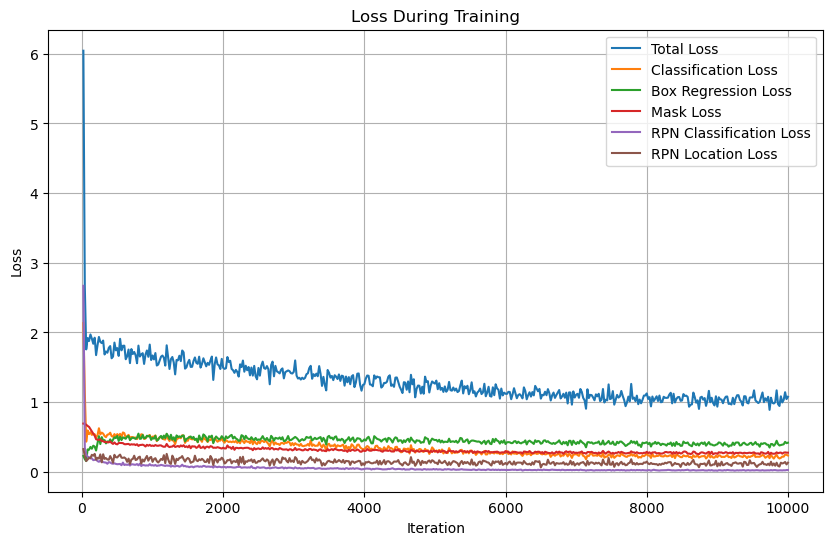

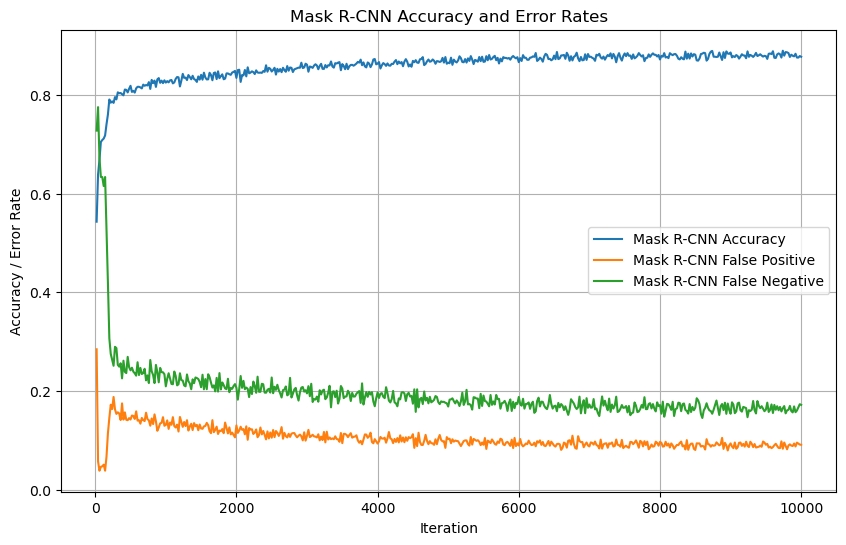

In [4]:
import matplotlib.pyplot as plt
#(Loss) 
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], df['total_loss'], label='Total Loss')
plt.plot(df['iteration'], df['loss_cls'], label='Classification Loss')
plt.plot(df['iteration'], df['loss_box_reg'], label='Box Regression Loss')
plt.plot(df['iteration'], df['loss_mask'], label='Mask Loss')
plt.plot(df['iteration'], df['loss_rpn_cls'], label='RPN Classification Loss')
plt.plot(df['iteration'], df['loss_rpn_loc'], label='RPN Location Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.grid(True)
plt.show()

#  Mask R-CNN Accuracy, False Positive, False Negative 
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], df['mask_rcnn/accuracy'], label='Mask R-CNN Accuracy')
plt.plot(df['iteration'], df['mask_rcnn/false_positive'], label='Mask R-CNN False Positive')
plt.plot(df['iteration'], df['mask_rcnn/false_negative'], label='Mask R-CNN False Negative')
plt.xlabel('Iteration')
plt.ylabel('Accuracy / Error Rate')
plt.title('Mask R-CNN Accuracy and Error Rates')
plt.legend()
plt.grid(True)
plt.show()

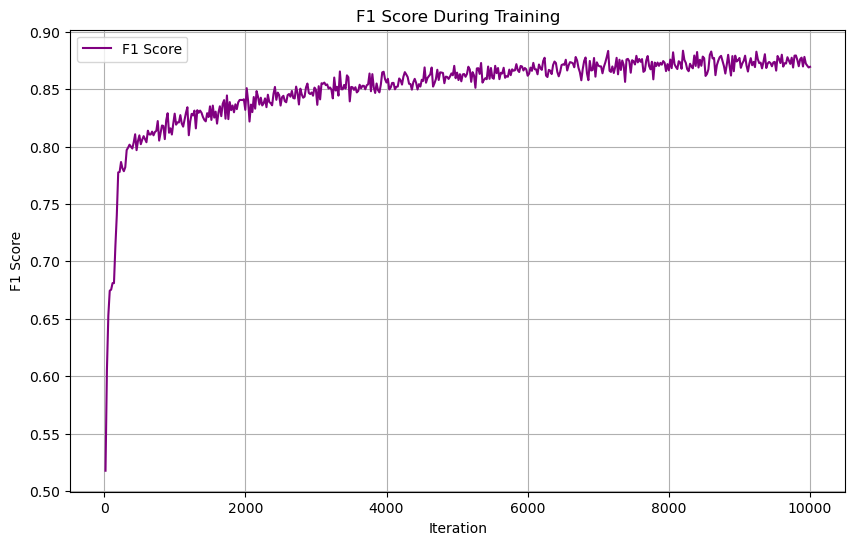

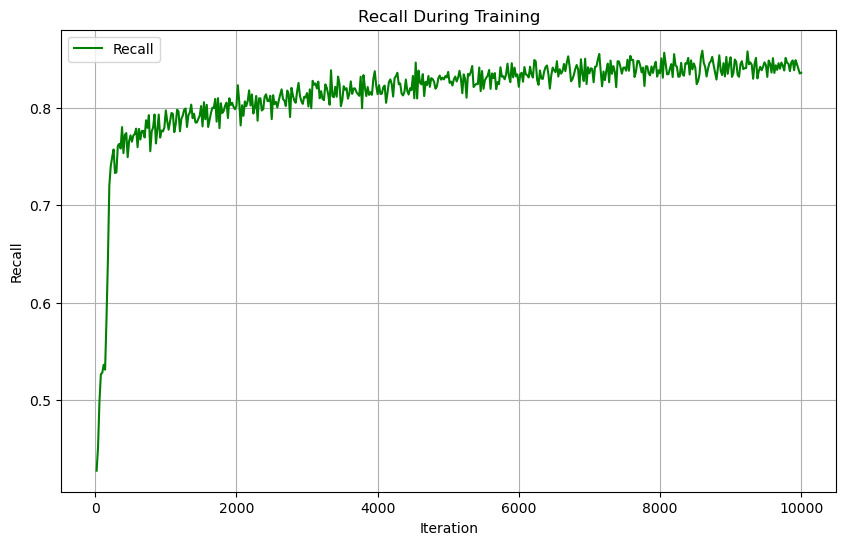

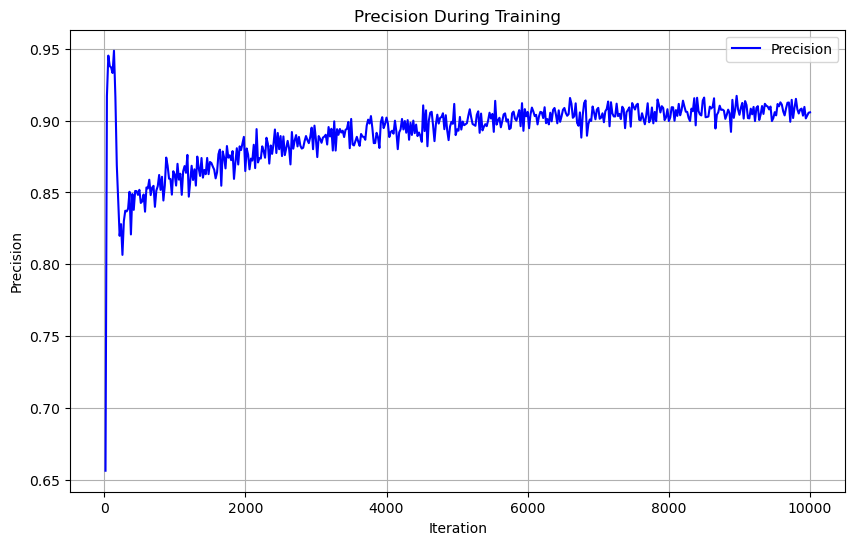

In [5]:
#f1 score
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], f1_score, label='F1 Score', color='purple')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('F1 Score During Training')
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], recall, label='Recall', color='green')
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.title('Recall During Training')
plt.legend()
plt.grid(True)
plt.show()

# Precision
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], precision, label='Precision', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Precision')
plt.title('Precision During Training')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
df = df.assign(precision=precision, recall=recall, f1_score=f1_score, accuracy=accuracy)
result_table = df[['iteration', 'precision', 'recall', 'f1_score', 'accuracy']]
result_table

,iteration,precision,recall,f1_score,accuracy
0,19,0.656123,0.427403,0.517622,0.542927
1,39,0.917025,0.451661,0.605229,0.638270
2,59,0.945295,0.498549,0.652807,0.667980
3,79,0.938038,0.526518,0.674463,0.704470
4,99,0.936981,0.527968,0.675377,0.708328
...,...,...,...,...,...
495,9919,0.909554,0.848870,0.878165,0.882974
496,9939,0.901553,0.844927,0.872322,0.875363
497,9959,0.903476,0.839875,0.870515,0.875188
498,9979,0.905551,0.835185,0.868946,0.878367


{'instances': Instances(num_instances=5, image_height=171, image_width=295, fields=[pred_boxes: Boxes(tensor([[205.8757,  77.5888, 267.0711,  93.0584],
        [228.7939,  84.9257, 283.9881, 145.7936],
        [ 64.4197,  85.1084,  81.1153, 101.8520],
        [199.8920,  93.2682, 234.2780, 102.9096],
        [ 75.4739, 104.5685,  80.3296, 110.9935]], device='cuda:0')), scores: tensor([0.9054, 0.8121, 0.6073, 0.6020, 0.5932], device='cuda:0'), pred_classes: tensor([2, 2, 1, 1, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False

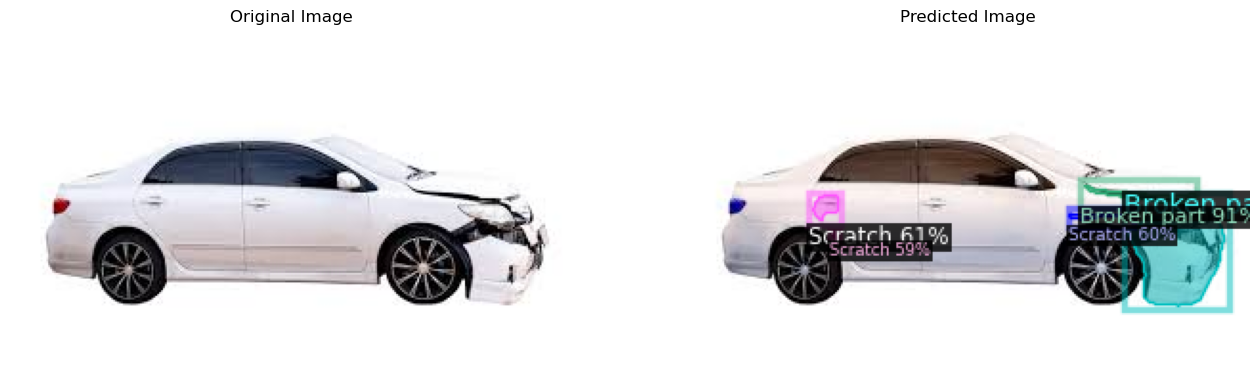

In [13]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer


# Load image
im = cv2.imread(r"C:\Users\kurt_\Downloads\hasar9.jpg")

# Make predictions using the predictor
output = predictor(im)

print(output)

# Visualize original image
plt.subplot(1, 2, 1)
plt.imshow(im[:, :, ::-1])
plt.title('Original Image')
plt.axis('off')

# Draw the predictions on the test image
v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_instance_predictions(output["instances"].to("cpu"))

# Show the image with predictions
plt.subplot(1, 2, 2)
plt.imshow(out.get_image()[:, :, ::-1])
plt.title('Predicted Image')
plt.axis('off')

plt.show()